<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')
house.head()
house.shape

(1460, 81)

In [3]:
house.LotFrontage.isnull().sum()
house.LotFrontage=house.LotFrontage.fillna(0.0)

In [4]:
house.columns

Index([u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street', u'Alley', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'MasVnrArea', u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1',
       u'BsmtFinType2', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'KitchenQual', u'TotRmsAbvGrd', u'Functional',
       u'Fireplaces', u'FireplaceQu', u'GarageType', u'GarageYrBlt',
       u'GarageFinish',

In [5]:
reno_able=house[['OverallQual','OverallCond','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','ExterQual','ExterCond','BsmtCond',
                 'BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','LowQualFinSF','KitchenQual','FireplaceQu'
                 ,'GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence']]
reno_col=reno_able.columns
reno_able.shape

(1460, 24)

In [6]:
fix=house.drop(reno_col,axis=1)
fix.shape

(1460, 57)

In [7]:
fix.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,3SsnPorch,ScreenPorch,PoolArea,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,0,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,0,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,0,NaN,0,12,2008,WD,Normal,250000


In [8]:
fix.MSZoning.value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [9]:
c=fix[fix['MSZoning']=='C (all)']
fix=fix.drop(c.index)
fix.MSZoning.value_counts()
X_all=fix

In [10]:
fix.head()
fix.shape

(1450, 57)

In [11]:
def nearZeroVariance(X, freqCut = 95 / 5, uniqueCut = 10):
    '''
    Determine predictors with near zero or zero variance.
    Inputs:
    X: pandas data frame
    freqCut: the cutoff for the ratio of the most common value to the second most common value
    uniqueCut: the cutoff for the percentage of distinct values out of the number of total samples
    Returns a tuple containing a list of column names: (zeroVar, nzVar)
    '''

    colNames = X.columns.values.tolist()
    freqRatio = dict()
    uniquePct = dict()

    for names in colNames:
        counts = (
            (X[names])
            .value_counts()
            .sort_values(ascending = False)
            .values
            )

        if len(counts) == 1:
            freqRatio[names] = -1
            uniquePct[names] = (len(counts) / len(X[names])) * 100
            continue

        freqRatio[names] = counts[0] / counts[1]
        uniquePct[names] = (len(counts) / len(X[names])) * 100

    zeroVar = list()
    nzVar = list()
    for k in uniquePct.keys():
        if freqRatio[k] == -1:
            zeroVar.append(k)

        if uniquePct[k] < uniqueCut and freqRatio[k] > freqCut:
            nzVar.append(k)

    return(zeroVar, nzVar)

nzv=nearZeroVariance(fix)
nzv=nzv[1]
nzv

['3SsnPorch',
 'OpenPorchSF',
 '2ndFlrSF',
 'MasVnrArea',
 'EnclosedPorch',
 'MiscVal',
 'Utilities',
 'KitchenAbvGr',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'MiscFeature',
 'LandSlope',
 'Condition2',
 'LandContour',
 'PoolArea',
 'ScreenPorch',
 'Functional',
 'Street']

In [12]:
print(fix['Alley'].value_counts())
fix1=fix.drop(nzv+['Alley']+['SaleCondition']+['SaleType']+['SalePrice'],axis=1)
print(fix1.shape)

Grvl    50
Pave    39
Name: Alley, dtype: int64
(1450, 35)


In [13]:
MSZDummies=pd.get_dummies(fix1.MSZoning,prefix='MSZ')
print(MSZDummies.var())
print(MSZDummies.MSZ_RH.value_counts())
MSZDummies=MSZDummies.drop(['MSZ_RH'],axis=1)

MSZ_FV    0.042848
MSZ_RH    0.010920
MSZ_RL    0.163799
MSZ_RM    0.127829
dtype: float64
0    1434
1      16
Name: MSZ_RH, dtype: int64


In [14]:
LSDummies=pd.get_dummies(fix1.LotShape,prefix='LS')
LSDummies=LSDummies.drop(['LS_IR3'],axis=1)

In [15]:
LCDummies=pd.get_dummies(fix1.LotConfig,prefix='LC')
LCDummies=LCDummies.drop(['LC_FR3'],axis=1)

In [16]:
NDummies=pd.get_dummies(fix1.Neighborhood,prefix='N')
NDummies=NDummies.drop(['N_Blueste'],axis=1)

In [17]:
CDummies=pd.get_dummies(fix1.Condition1,prefix='C')
CDummies=CDummies.drop(['C_RRNe'],axis=1)

In [18]:
BTDummies=pd.get_dummies(fix1.BldgType,prefix='BT')
BTDummies=BTDummies.drop(['BT_TwnhsE'],axis=1)

In [19]:
HSDummies=pd.get_dummies(fix1.HouseStyle,prefix='HS')
HSDummies=HSDummies.drop(['HS_2.5Unf'],axis=1)

In [20]:
MVDummies=pd.get_dummies(fix1.MasVnrType,prefix='MV')
MVDummies=MVDummies.drop(['MV_BrkCmn'],axis=1)

In [21]:
FDummies=pd.get_dummies(fix1.Foundation,prefix='F')
FDummies=FDummies.drop(['F_Wood'],axis=1)

In [22]:
BQDummies=pd.get_dummies(fix1.BsmtQual,prefix='BQ')
BQDummies=BQDummies.drop(['BQ_Fa'],axis=1)

In [23]:
BEDummies=pd.get_dummies(fix1.BsmtExposure,prefix='BE')
BEDummies=BEDummies.drop(['BE_Mn'],axis=1)

In [24]:
GTDummies=pd.get_dummies(fix1.GarageType,prefix='GT')
GTDummies=GTDummies.drop(['GT_CarPort'],axis=1)

In [25]:
fix1.columns

Index([u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'LotShape', u'LotConfig', u'Neighborhood', u'Condition1', u'BldgType',
       u'HouseStyle', u'YearBuilt', u'YearRemodAdd', u'MasVnrType',
       u'Foundation', u'BsmtQual', u'BsmtExposure', u'BsmtUnfSF',
       u'TotalBsmtSF', u'1stFlrSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'TotRmsAbvGrd', u'Fireplaces', u'GarageType', u'GarageYrBlt',
       u'GarageCars', u'GarageArea', u'WoodDeckSF', u'MoSold', u'YrSold'],
      dtype='object')

In [26]:
drop=['MSZoning','LotShape','LotConfig','Neighborhood','Condition1','BldgType','HouseStyle','MasVnrType','BsmtQual',
     'Foundation','BsmtExposure','GarageType','Id']
fix1=fix1.drop(drop,axis=1)

In [27]:
fix1=pd.concat([fix1,MSZDummies,LSDummies,LCDummies,NDummies,CDummies,BTDummies,HSDummies,MVDummies,BQDummies,FDummies,BEDummies,GTDummies],axis=1)
fix1.GarageYrBlt=fix1.GarageYrBlt.fillna(0.0)
fix1.shape

(1450, 94)

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet,RidgeCV, LassoCV, ElasticNetCV, LogisticRegression
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVR,SVC
from sklearn.feature_selection import RFE
import xgboost
X=fix1
names=X.columns
ss = StandardScaler()
Xs = ss.fit_transform(X)
Xs.shape
names
X_train=X[X.YrSold<2010]
Xs_train=ss.fit_transform(X_train)
X_test=X[X.YrSold==2010]
Xs_test=ss.transform(X_test)
y_train=fix[fix.YrSold<2010]
y_train=y_train.SalePrice
y_test=fix[fix.YrSold==2010]
y_test=y_test.SalePrice
y=fix.SalePrice

/Users/phuahweeliang/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/phuahweeliang/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [29]:
lr=LinearRegression()

In [30]:
lr.fit(X_train,y_train)
lr.score(X_test,y_test)

0.86654239511950093

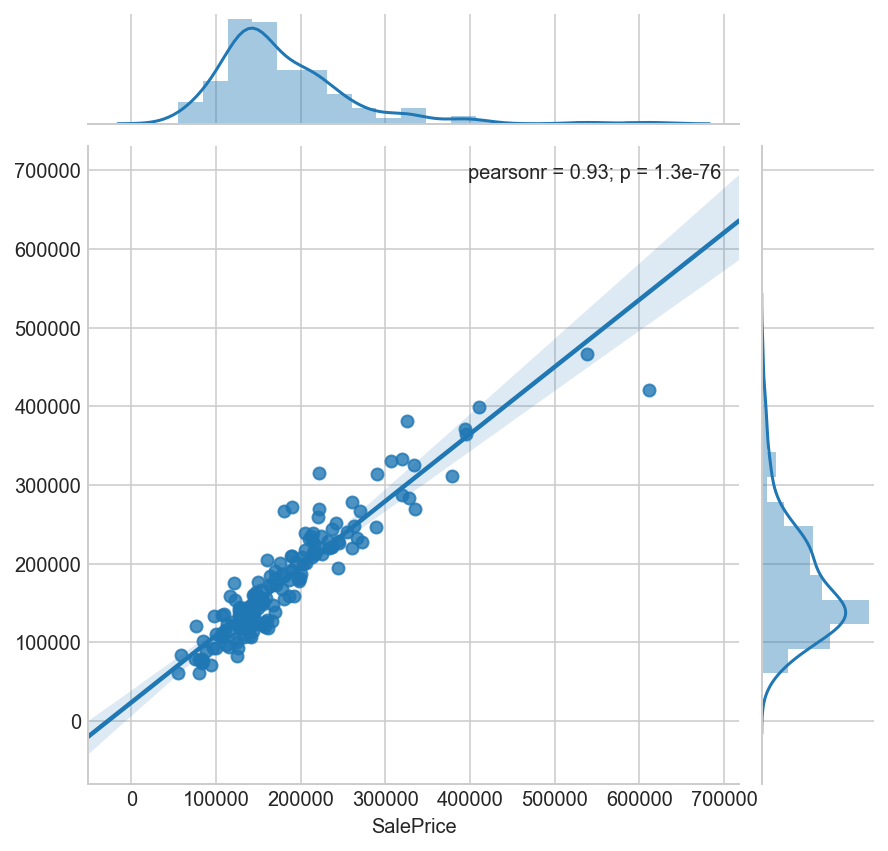

In [31]:
yhat = lr.predict(X_test)
sns.jointplot(y_test, yhat,kind='reg')

In [32]:
ridge=Ridge()
ridge.fit(Xs_train,y_train)
ridge.score(Xs_test,y_test)

0.86637173884202601

In [33]:
lasso=Lasso()
lasso.fit(Xs_train,y_train)
lasso.score(Xs_test,y_test)

/Users/phuahweeliang/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.86651353298633904

In [34]:
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)


In [35]:
selector = RFE(lr)
selector = selector.fit(Xs, y)
selector.support_
ranking= sorted(zip(map(lambda x: round(x, 4), selector.ranking_), names))

In [36]:
rfe_columns = np.array(names)[selector.support_]
rfe_columns

array(['MSSubClass', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'LS_IR1', 'LS_IR2', 'LS_Reg',
       'LC_Corner', 'LC_CulDSac', 'LC_Inside', 'N_Crawfor', 'N_Edwards',
       'N_Mitchel', 'N_NoRidge', 'N_NridgHt', 'N_Somerst', 'N_StoneBr',
       'N_Veenker', 'C_Feedr', 'C_RRAe', 'BT_1Fam', 'BT_2fmCon',
       'HS_1Story', 'HS_2Story', 'MV_BrkFace', 'MV_None', 'MV_Stone',
       'BQ_Ex', 'BE_Av', 'BE_Gd', 'BE_No', 'GT_Attchd', 'GT_Basment',
       'GT_BuiltIn', 'GT_Detchd'], dtype=object)

In [37]:
rfe_columns=rfe_columns.tolist()
rfe_columns.append('YrSold')

In [38]:
X1=X[rfe_columns]
X1_train=X1[X1.YrSold<2010]
X1_train=X1_train.drop(['YrSold'],axis=1)

In [39]:
X1_test=X1[X1.YrSold==2010]
X1_test=X1_test.drop(['YrSold'],axis=1)
X1s_train=ss.fit_transform(X1_train)
X1s_test=ss.transform(X1_test)

In [40]:
lr.fit(X1s_train,y_train)
lr.score(X1s_test,y_test)

0.87335492285119165

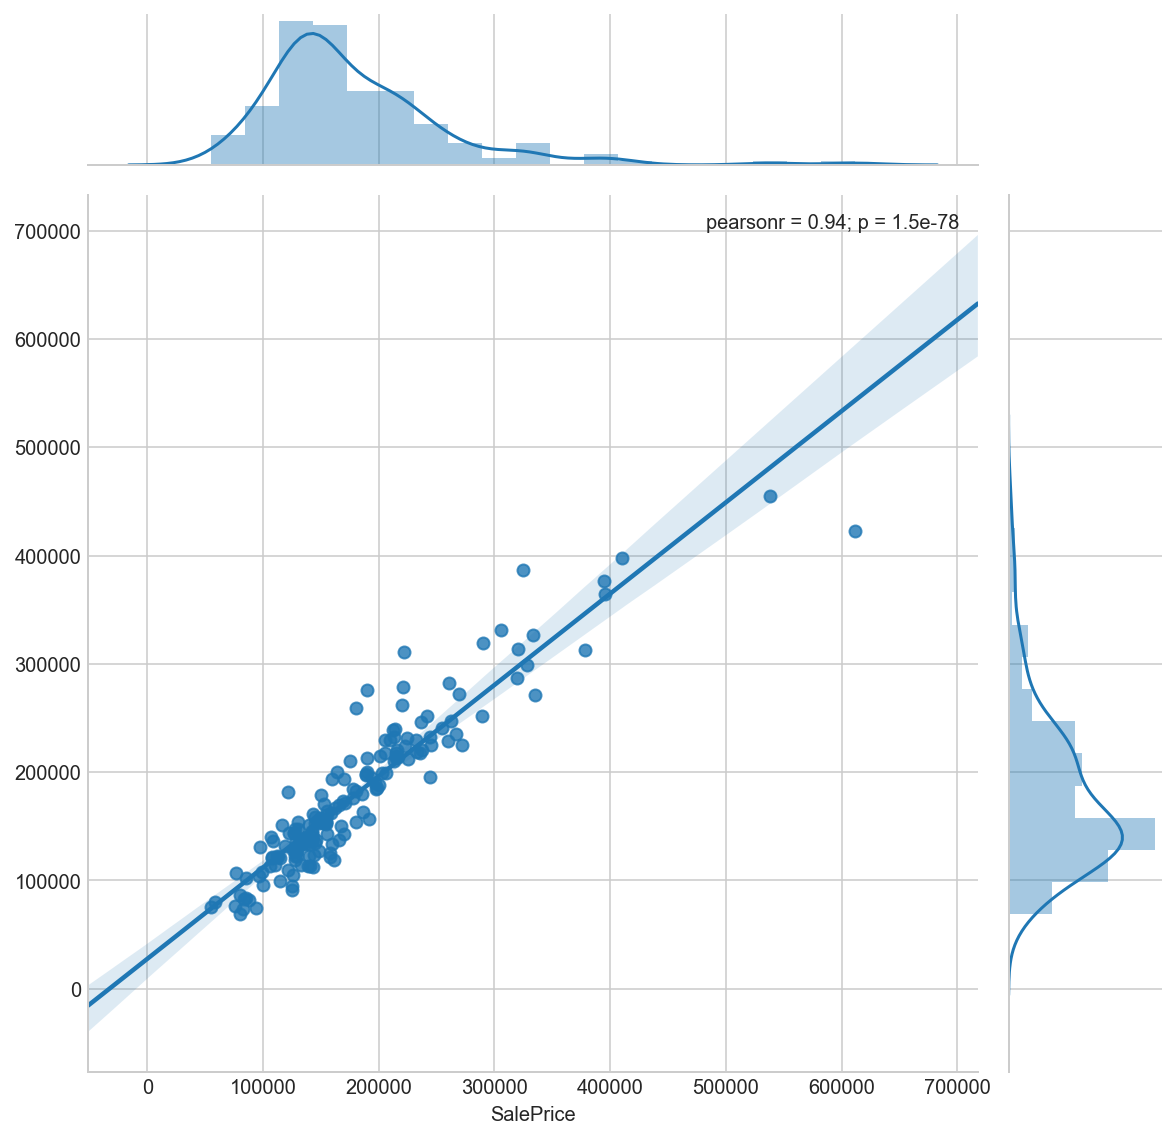

In [41]:
yhat3 = lr.predict(X1s_test)
sns.jointplot(y_test, yhat3,kind='reg',size=8)

In [42]:
lr_coefs = pd.DataFrame({'variable':X1_train.columns,
                            'coef':lr.coef_,
                            'abs_coef':np.abs(lr.coef_)})

lr_coefs.sort_values('abs_coef', inplace=True, ascending=False)

In [43]:
from IPython.display import display,HTML

CSS = """
div.cell:nth-child(46) .output {
    flex-direction: row;
}
"""
HTML('<style>{}</style>'.format(CSS))

In [44]:
display(lasso_coefs.head(47))
display(lr_coefs)

,abs_coef,coef,variable
8,38187.271472,38187.271472,GrLivArea
27,17942.921951,17942.921951,LS_Reg
25,16400.820618,16400.820618,LS_IR1
78,13218.163377,13218.163377,BQ_Ex
17,10517.627798,10517.627798,GarageCars
7,10500.712385,-10500.712385,1stFlrSF
47,10399.026195,10399.026195,N_NridgHt
90,10040.582525,10040.582525,GT_Attchd
70,9706.842717,9706.842717,HS_1Story
31,9150.708202,9150.708202,LC_Inside


,abs_coef,coef,variable
7,31027.301133,31027.301133,GrLivArea
18,20650.358808,20650.358808,LS_Reg
16,19401.685241,19401.685241,LS_IR1
43,13407.046721,13407.046721,GT_Attchd
46,12097.063927,12097.063927,GT_Detchd
39,12016.694627,12016.694627,BQ_Ex
26,11474.305440,11474.305440,N_NridgHt
25,10995.286957,10995.286957,N_NoRidge
15,9796.116228,9796.116228,GarageCars
17,8863.072122,8863.072122,LS_IR2


In [45]:
lasso=Lasso()
lasso.fit(X1s_train,y_train)
lasso.score(X1s_test,y_test)

0.8733366948173622

In [46]:
ridge=Ridge()
ridge.fit(X1s_train,y_train)
ridge.score(X1s_test,y_test)

0.87312695720837918

In [47]:
# Perform cross-validation
scores = cross_val_score(lr, X1s_train, y_train, cv=5)
print "Cross-validated scores:", scores
print "Mean CV R2:", np.mean(scores)
print 'Std CV R2:', np.std(scores)
    
# Make cross-validated predictions
predictions = cross_val_predict(lr, X1s_train, y_train, cv=5)
    
r2 = metrics.r2_score(y_train, predictions)
print "Cross-Predicted R2:", r2
lr.score(X1s_test,y_test)

Cross-validated scores: [ 0.87613792  0.80489617  0.84809853  0.85435371  0.68726283]
Mean CV R2: 0.814149832745
Std CV R2: 0.0675238214159
Cross-Predicted R2: 0.810164406813


0.87335492285119165

In [48]:
# Perform cross-validation
scores = cross_val_score(lasso, X1s_train, y_train, cv=5)
print "Cross-validated scores:", scores
print "Mean CV R2:", np.mean(scores)
print 'Std CV R2:', np.std(scores)
    
# Make cross-validated predictions
predictions = cross_val_predict(lasso, X1s_train, y_train, cv=5)
    
r2 = metrics.r2_score(y_train, predictions)
print "Cross-Predicted R2:", r2
lasso.score(X1s_test,y_test)

Cross-validated scores: [ 0.87617387  0.80491434  0.84807125  0.85441575  0.68735953]
Mean CV R2: 0.814186948269
Std CV R2: 0.0674982315254
Cross-Predicted R2: 0.810197535255


0.8733366948173622

In [49]:
xgb = xgboost.XGBRegressor(n_estimators=100, booster='gbtree',learning_rate=0.08, gamma=0, min_child_weight=6,subsample=0.8,colsample_bytree=1, max_depth=7)

In [50]:
param_test = {
 'max_depth':[4,5,6,7,8,9],
 'min_child_weight':[4,5,6,7,8,9]
}
gs = GridSearchCV(xgb,param_test,cv=10, n_jobs=-1)
gs.fit(X1s_train,y_train)
gs.best_params_

{'max_depth': 5, 'min_child_weight': 4}

In [51]:
xgb1 = xgboost.XGBRegressor(n_estimators=100, booster='gbtree',learning_rate=0.08, gamma=0, min_child_weight=4,subsample=0.8,colsample_bytree=1, max_depth=5)

In [52]:
xgb1.fit(X1s_train,y_train)
xgb1.score(X1s_test,y_test)

0.88879884171117662

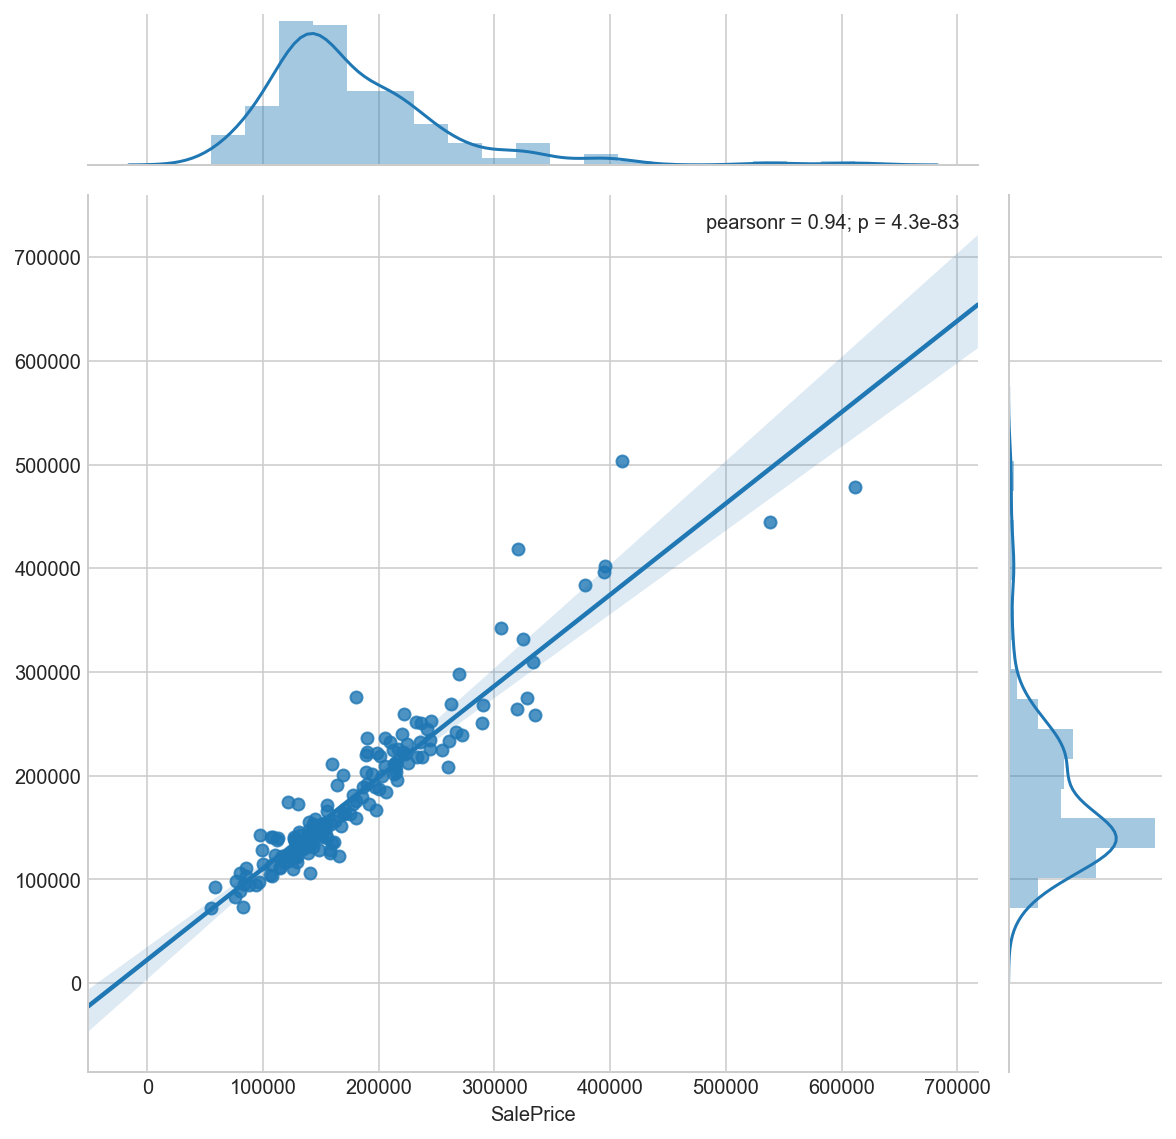

In [53]:
yhat4 = xgb1.predict(X1s_test)
sns.jointplot(y_test, yhat4,kind='reg',size=8)

In [54]:
# Perform cross-validation
scores = cross_val_score(xgb1, X1s_train, y_train, cv=5)
print "Cross-validated scores:", scores
print "Mean CV R2:", np.mean(scores)
print 'Std CV R2:', np.std(scores)
    
    # Make cross-validated predictions
predictions = cross_val_predict(xgb1, X1s_train, y_train, cv=5)
r2 = metrics.r2_score(y_train, predictions)
print "Cross-Predicted R2:", r2

Cross-validated scores: [ 0.87367461  0.80025342  0.8882972   0.88307397  0.85859002]
Mean CV R2: 0.860777844978
Std CV R2: 0.0319021970754
Cross-Predicted R2: 0.859547992695


In [55]:
from sklearn.ensemble import BaggingRegressor
bagging = BaggingRegressor(base_estimator = xgb1)
bagging.fit(X1s_train,y_train)
print(bagging.score(X1s_test,y_test))

0.887648013205


In [56]:
# Perform cross-validation
scores = cross_val_score(bagging, X1s_train, y_train, cv=5)
print "Cross-validated scores:", scores
print "Mean CV R2:", np.mean(scores)
print 'Std CV R2:', np.std(scores)
    
    # Make cross-validated predictions
predictions = cross_val_predict(bagging, X1s_train, y_train, cv=5)
r2 = metrics.r2_score(y_train, predictions)
print "Cross-Predicted R2:", r2

Cross-validated scores: [ 0.88758363  0.80553486  0.88137684  0.89454134  0.82785559]
Mean CV R2: 0.85937845099
Std CV R2: 0.0358014335018
Cross-Predicted R2: 0.851261488979


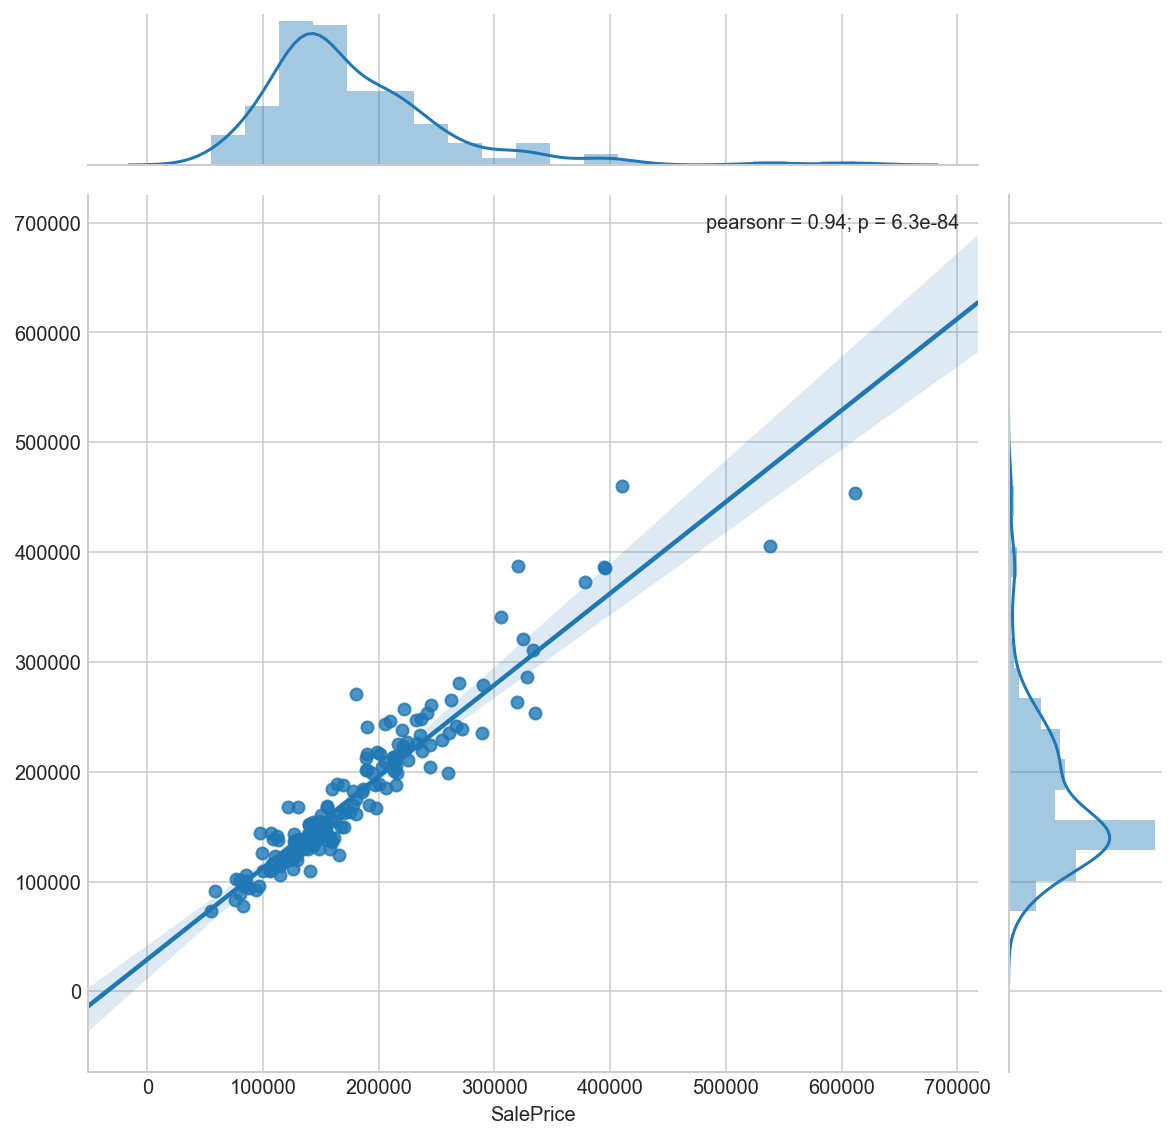

In [57]:
yhat5 = bagging.predict(X1s_test)
sns.jointplot(y_test, yhat5, kind='reg',size=8)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [58]:
reno_able.head()

,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,BsmtCond,BsmtFinType1,...,Electrical,LowQualFinSF,KitchenQual,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence
0,7,5,Gable,CompShg,VinylSd,VinylSd,Gd,TA,TA,GLQ,...,SBrkr,0,Gd,NaN,RFn,TA,TA,Y,NaN,NaN
1,6,8,Gable,CompShg,MetalSd,MetalSd,TA,TA,TA,ALQ,...,SBrkr,0,TA,TA,RFn,TA,TA,Y,NaN,NaN
2,7,5,Gable,CompShg,VinylSd,VinylSd,Gd,TA,TA,GLQ,...,SBrkr,0,Gd,TA,RFn,TA,TA,Y,NaN,NaN
3,7,5,Gable,CompShg,Wd Sdng,Wd Shng,TA,TA,Gd,ALQ,...,SBrkr,0,Gd,Gd,Unf,TA,TA,Y,NaN,NaN
4,8,5,Gable,CompShg,VinylSd,VinylSd,Gd,TA,TA,GLQ,...,SBrkr,0,Gd,TA,RFn,TA,TA,Y,NaN,NaN


In [59]:
reno=reno_able[['OverallQual','OverallCond','LowQualFinSF']]
reno_dummies=reno_able.drop(['OverallQual','OverallCond','LowQualFinSF'],axis=1)
reno_dummies=pd.get_dummies(reno_dummies,drop_first=True)
reno=pd.concat([reno,reno_dummies],axis=1)
reno['YrSold']=house.YrSold
reno['MSZoning']=house.MSZoning

In [60]:
#c=fix[fix['MSZoning']=='C (all)']
reno=reno.drop(c.index)
reno.MSZoning.value_counts()
reno=reno.drop(['MSZoning'],axis=1)
reno.head()

,OverallQual,OverallCond,LowQualFinSF,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,...,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,PoolQC_Fa,PoolQC_Gd,Fence_GdWo,Fence_MnPrv,Fence_MnWw,YrSold
0,7,5,0,1,0,0,0,0,1,0,...,0,1,0,1,0,0,0,0,0,2008
1,6,8,0,1,0,0,0,0,1,0,...,0,1,0,1,0,0,0,0,0,2007
2,7,5,0,1,0,0,0,0,1,0,...,0,1,0,1,0,0,0,0,0,2008
3,7,5,0,1,0,0,0,0,1,0,...,0,1,0,1,0,0,0,0,0,2006
4,8,5,0,1,0,0,0,0,1,0,...,0,1,0,1,0,0,0,0,0,2008


In [61]:
Xrs=ss.fit_transform(reno)

In [62]:
Xr_train=reno[reno.YrSold<2010]
Xrs_train=ss.fit_transform(Xr_train)
Xr_test=reno[reno.YrSold==2010]
Xrs_test=ss.transform(Xr_test)
Xrs_train.shape

(1278, 103)

In [63]:
Xrs_test.shape

(172, 103)

In [64]:
yvar_test=yhat5-y_test
yvar_test.shape

(172,)

In [65]:
yhat5_train=xgb1.predict(X1s_train)
yvar_train=yhat5_train-y_train
yvar_train.shape

(1278,)

In [66]:
lr.fit(Xrs_train,yvar_train)
lr.score(Xrs_test,yvar_test)


-1.6240110506463881e+19

In [67]:
lasso.fit(Xrs_train,yvar_train)
lasso.score(Xrs_test,yvar_test)

0.059215040420366183

In [68]:
ridge.fit(Xrs_train,yvar_train)
ridge.score(Xrs_test,yvar_test)

0.059313350930315867

In [69]:
nzv1=nearZeroVariance(reno)
nzv1=nzv1[1]
nzv1

['PoolQC_Fa',
 'BsmtFinType2_LwQ',
 'RoofMatl_Tar&Grv',
 'Fence_GdWo',
 'GarageCond_Po',
 'PoolQC_Gd',
 'RoofMatl_Metal',
 'Heating_GasA',
 'Heating_Grav',
 'HeatingQC_Po',
 'RoofMatl_WdShngl',
 'BsmtCond_Gd',
 'RoofStyle_Mansard',
 'Heating_Wall',
 'Exterior1st_WdShing',
 'BsmtFinType2_Rec',
 'GarageQual_Po',
 'GarageCond_Fa',
 'Exterior2nd_AsphShn',
 'HeatingQC_Fa',
 'ExterCond_Fa',
 'BsmtCond_Po',
 'BsmtFinType2_GLQ',
 'Exterior1st_BrkComm',
 'RoofMatl_Membran',
 'RoofStyle_Shed',
 'Electrical_FuseP',
 'Heating_GasW',
 'Exterior1st_Stone',
 'GarageQual_Fa',
 'Exterior2nd_Brk Cmn',
 'Exterior1st_CBlock',
 'Heating_OthW',
 'Exterior2nd_Other',
 'Exterior2nd_ImStucc',
 'Electrical_FuseF',
 'Exterior1st_BrkFace',
 'GarageQual_Gd',
 'RoofMatl_CompShg',
 'ExterCond_Po',
 'Exterior2nd_CmentBd',
 'Exterior1st_Stucco',
 'LowQualFinSF',
 'GarageCond_Gd',
 'Electrical_Mix',
 'BsmtFinType2_BLQ',
 'PavedDrive_P',
 'RoofMatl_WdShake',
 'RoofStyle_Gambrel',
 'RoofMatl_Roll',
 'Exterior1st_ImStucc'

In [70]:
reno1=reno.drop(nzv1,axis=1)

In [71]:
Xrn_train=reno1[reno1.YrSold<2010]
Xrns_train=ss.fit_transform(Xrn_train)
Xrn_test=reno1[reno1.YrSold==2010]
Xrns_test=ss.fit_transform(Xrn_test)

In [72]:
selector1 = RFE(lr)
selector1 = selector1.fit(Xrns_train,yvar_train)

In [73]:
names1=Xrn_train.columns
rfe1_columns = np.array(names1)[selector1.support_]
rfe1_columns

array(['OverallQual', 'OverallCond', 'Exterior1st_HdBoard',
       'Exterior1st_MetalSd', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng',
       'Exterior2nd_MetalSd', 'Exterior2nd_Wd Sdng', 'ExterQual_Gd',
       'ExterQual_TA', 'ExterCond_Gd', 'BsmtFinType1_LwQ',
       'BsmtFinType1_Rec', 'BsmtFinType1_Unf', 'Electrical_SBrkr',
       'KitchenQual_Gd', 'FireplaceQu_TA', 'GarageFinish_Unf',
       'PavedDrive_Y', 'YrSold'], dtype=object)

In [74]:
rfe1_columns=rfe1_columns.tolist()
Xr1_train=Xr_train[rfe1_columns]
Xr1s_train=ss.fit_transform(Xr1_train)

In [75]:
Xr1_test=Xr_test[rfe1_columns]
Xr1s_test=ss.fit_transform(Xr1_test)

In [76]:
lr.fit(Xr1s_train,yvar_train)
lr.score(Xr1s_test,yvar_test)

0.054185840852640332

In [77]:
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xr1s_train, yvar_train)

print optimal_ridge.alpha_

81.1984499318


In [78]:
ridge1 = Ridge(alpha=optimal_ridge.alpha_)
ridge1.fit(Xr1s_train,yvar_train)

ridge_scores = cross_val_score(ridge1, Xr1s_train, yvar_train, cv=10)

print ridge_scores
print np.mean(ridge_scores)
print ridge1.score(Xr1s_test,yvar_test)

[ 0.10315599  0.15796198  0.21660613 -0.00300699  0.13369588  0.04297001
  0.14605488  0.22287934  0.10904617  0.00431001]
0.113367340696
0.056263230895


In [79]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xr1s_train, yvar_train)

print optimal_lasso.alpha_

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

68.2161283796


...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished


In [80]:
lasso1 = Lasso(alpha=optimal_lasso.alpha_)
lasso1.fit(Xr1s_train,yvar_train)
lasso1.score(Xr1s_test,yvar_test)
#lasso_scores = cross_val_score(lasso, Xs, y, cv=10)

#print lasso_scores
#print np.mean(lasso_scores)

0.057788672584934024

In [81]:
r1=ridge.fit(Xrs_train,yvar_train)
ridge.score(Xrs_test,yvar_test)

0.059313350930315645

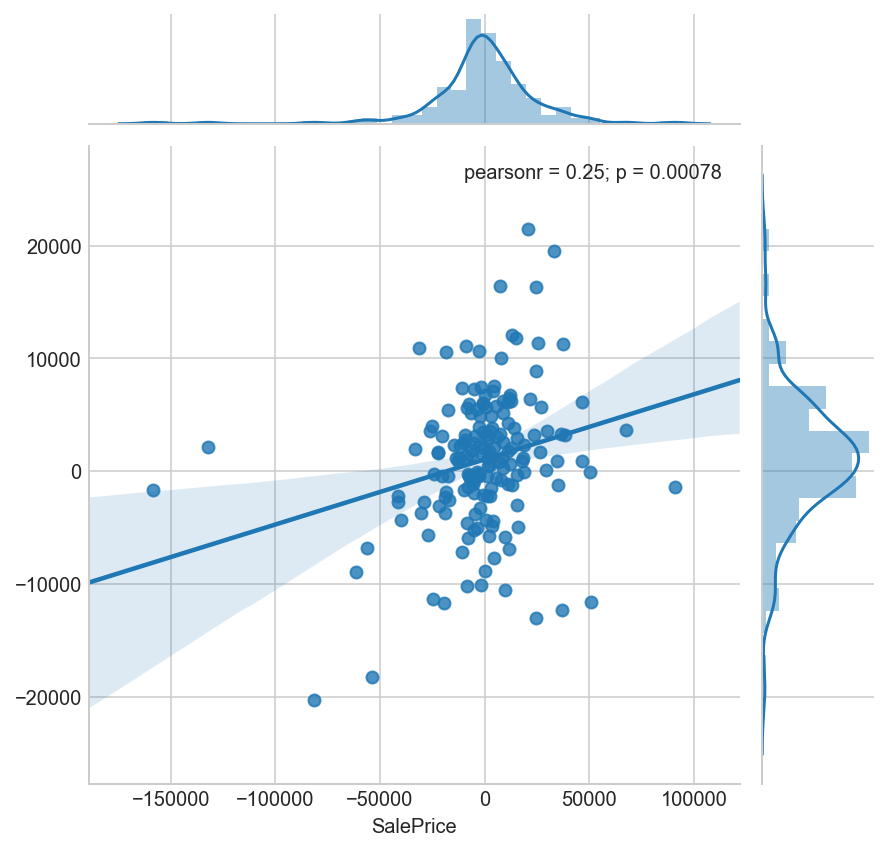

In [82]:
yhat7 = r1.predict(Xrs_test)
sns.jointplot(yvar_test, yhat7, kind='reg',size=6)

In [83]:
xgb3 = xgboost.XGBRegressor(n_estimators=100, booster='gbtree',learning_rate=0.08, gamma=0, min_child_weight=6,subsample=0.8,colsample_bytree=1, max_depth=7)

In [84]:
param_test = {
 'max_depth':[4,5,6,7,8,9],
 'min_child_weight':[4,5,6,7,8,9]
}
gs = GridSearchCV(xgb3,param_test,cv=10, n_jobs=-1)
gs.fit(Xrs_train,yvar_train)
gs.best_params_


{'max_depth': 4, 'min_child_weight': 9}

In [85]:
xgb4 = xgboost.XGBRegressor(n_estimators=100, booster='gbtree',learning_rate=0.08, gamma=0, min_child_weight=9,subsample=0.8,colsample_bytree=1, max_depth=4)

In [86]:
xgb4.fit(Xr1s_train,yvar_train)
xgb4.score(Xr1s_test,yvar_test)

0.051361309171380265

In [87]:
xgb5 = xgboost.XGBRegressor(n_estimators=100, booster='gbtree',learning_rate=0.08, gamma=0, min_child_weight=9,subsample=0.8,colsample_bytree=1, max_depth=4)

In [88]:
xgb5.fit(Xrs_train,yvar_train)
xgb5.score(Xrs_test,yvar_test)

0.054269132111933738

In [89]:
bagging1 = BaggingRegressor(base_estimator = lasso1)
bagging1.fit(Xr1s_train,yvar_train)
print(bagging1.score(Xr1s_test,yvar_test))

0.0519217870414


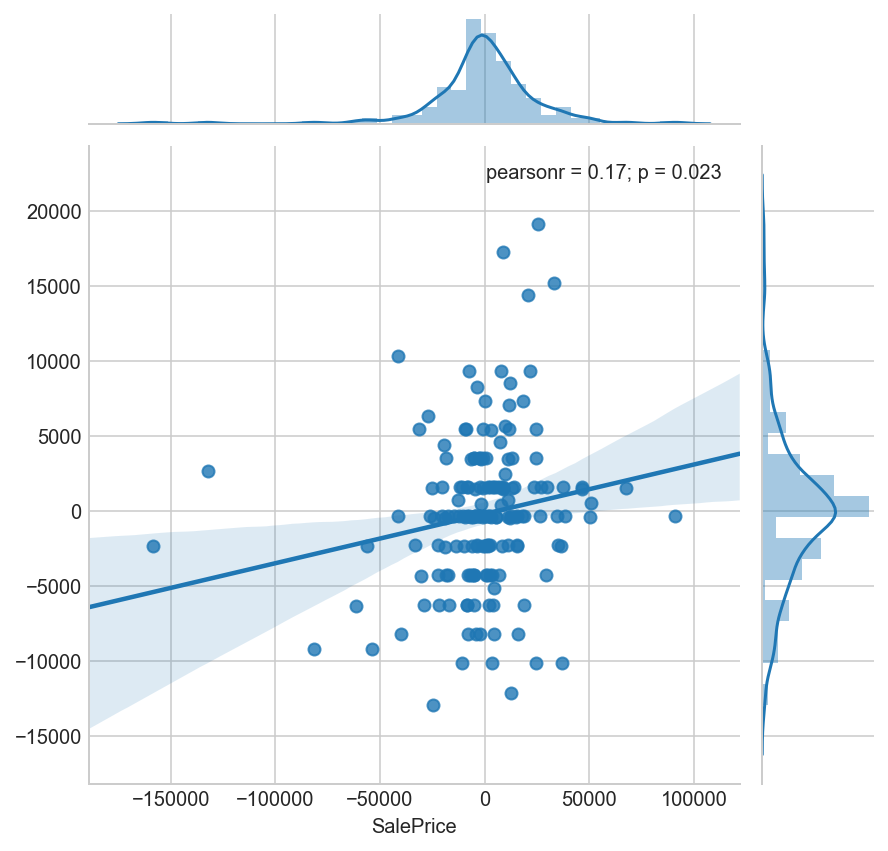

In [90]:
yhat8 = bagging1.predict(Xrs_test)
sns.jointplot(yvar_test, yhat8, kind='reg',size=6)

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [91]:
y_ab=house.SaleCondition.value_counts().values
y_ab1=pd.get_dummies(house.SaleCondition)
y_ab1=y_ab1.Abnorml.values
baseline=1-y_ab1.mean()
baseline

0.93082191780821921

In [92]:
# A:
house.dtypes
reno_able.head()

,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,BsmtCond,BsmtFinType1,...,Electrical,LowQualFinSF,KitchenQual,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence
0,7,5,Gable,CompShg,VinylSd,VinylSd,Gd,TA,TA,GLQ,...,SBrkr,0,Gd,NaN,RFn,TA,TA,Y,NaN,NaN
1,6,8,Gable,CompShg,MetalSd,MetalSd,TA,TA,TA,ALQ,...,SBrkr,0,TA,TA,RFn,TA,TA,Y,NaN,NaN
2,7,5,Gable,CompShg,VinylSd,VinylSd,Gd,TA,TA,GLQ,...,SBrkr,0,Gd,TA,RFn,TA,TA,Y,NaN,NaN
3,7,5,Gable,CompShg,Wd Sdng,Wd Shng,TA,TA,Gd,ALQ,...,SBrkr,0,Gd,Gd,Unf,TA,TA,Y,NaN,NaN
4,8,5,Gable,CompShg,VinylSd,VinylSd,Gd,TA,TA,GLQ,...,SBrkr,0,Gd,TA,RFn,TA,TA,Y,NaN,NaN


In [93]:
r=reno_able.drop(['OverallQual','OverallCond','LowQualFinSF'],axis=1)
r=r.columns
X_abl=house.drop(r,axis=1)
X_abl.dtypes
X_ab1=X_abl.drop(['MSZoning','Alley','Street','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood',
                 'Condition1','Condition2','BldgType','HouseStyle','MasVnrType','Foundation','BsmtQual','BsmtExposure',
                 'Functional','GarageType','MiscFeature','SaleType','SaleCondition'],axis=1)
X_ab1.MasVnrArea=X_ab1.MasVnrArea.fillna(0.0)
X_ab1.GarageYrBlt=X_ab1.GarageYrBlt.fillna(0.0)
X_ab1.isnull().sum()
X_ab1=X_ab1.fillna(0.0)
X_ab1=X_ab1.astype('float')
X_ab1.MasVnrArea=X_ab1.MasVnrArea.astype('float')
X_ab1.GarageYrBlt=X_ab1.GarageYrBlt.astype('float')
X_ab1.dtypes
X_ab1s=ss.fit_transform(X_ab1)

In [94]:
X_ab1.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,57.623288,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,34.664304,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,0.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,42.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,63.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [95]:
from sklearn.feature_selection import SelectKBest, chi2
skb_chi2 = SelectKBest(chi2, k=5)

#train the selector on our data
#skb_f.fit(X, y)
skb_chi2.fit(X_ab1, y_ab1)
#skb_f.scores_
#examine results
kbest = pd.DataFrame([X_ab1.columns, list(skb_chi2.scores_),list(skb_chi2.pvalues_)], 
                     index=['feature','chi2 score','chi2 pvalues']).T.sort_values('chi2 pvalues', ascending=True)
kbest=kbest.reset_index(drop=True)
kbest

,feature,chi2 score,chi2 pvalues
0,SalePrice,709488,0
1,LowQualFinSF,2985.11,0
2,BsmtFinSF2,1906.55,0
3,EnclosedPorch,1673.73,0
4,GarageYrBlt,1746.9,0
5,LotArea,11724.8,0
6,PoolArea,2396.15,0
7,MiscVal,2781.69,0
8,GarageArea,1322.31,1.60475e-289
9,MasVnrArea,889.084,2.31635e-195


In [96]:
kbest26=kbest.iloc[0:27,:]
kbest26

,feature,chi2 score,chi2 pvalues
0,SalePrice,709488,0
1,LowQualFinSF,2985.11,0
2,BsmtFinSF2,1906.55,0
3,EnclosedPorch,1673.73,0
4,GarageYrBlt,1746.9,0
5,LotArea,11724.8,0
6,PoolArea,2396.15,0
7,MiscVal,2781.69,0
8,GarageArea,1322.31,1.60475e-289
9,MasVnrArea,889.084,2.31635e-195


In [97]:
k=kbest26.feature
k=k.tolist()

In [98]:
d=house[['MSZoning','Alley','Street','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood',
                 'Condition1','Condition2','BldgType','HouseStyle','MasVnrType','Foundation','BsmtQual','BsmtExposure',
                 'Functional','GarageType','MiscFeature','SaleType']]
d=pd.get_dummies(d,drop_first=True)

In [99]:
skb2_chi2 = SelectKBest(chi2, k=5)

#train the selector on our data
#skb_f.fit(X, y)
skb2_chi2.fit(d, y_ab1)
skb2_chi2.pvalues_
#examine results
kbest2 = pd.DataFrame([d.columns, list(skb2_chi2.scores_),list(skb2_chi2.pvalues_)], 
                     index=['feature','chi2 score','chi2 pvalues']).T.sort_values('chi2 pvalues', ascending=True)
kbest2

,feature,chi2 score,chi2 pvalues
103,SaleType_Oth,40.3663,2.10538e-10
1,MSZoning_RH,14.7112,0.000125302
87,Functional_Sev,13.4554,0.000244296
12,Utilities_NoSeWa,13.4554,0.000244296
102,SaleType_New,9.06696,0.00260269
79,BsmtQual_TA,8.73258,0.00312574
27,Neighborhood_IDOTRR,8.27579,0.00401772
73,Foundation_PConc,6.74088,0.00942283
90,GarageType_Basment,5.89521,0.0151821
34,Neighborhood_NridgHt,5.72259,0.016748


In [100]:
kbest2=kbest2.reset_index(drop=True)
kbest223=kbest2.iloc[0:24,:]
k2=kbest223.feature
k2=k2.tolist()
X_ab2=pd.concat([X_ab1[k],d[k2]],axis=1)
X_ab2.head()

,SalePrice,LowQualFinSF,BsmtFinSF2,EnclosedPorch,GarageYrBlt,LotArea,PoolArea,MiscVal,GarageArea,MasVnrArea,...,MasVnrType_Stone,HouseStyle_2.5Fin,Neighborhood_Gilbert,SaleType_WD,Neighborhood_NAmes,Alley_Pave,Neighborhood_BrDale,GarageType_CarPort,SaleType_ConLD,BsmtExposure_Gd
0,208500.0,0.0,0.0,0.0,2003.0,8450.0,0.0,0.0,548.0,196.0,...,0,0,0,1,0,0,0,0,0,0
1,181500.0,0.0,0.0,0.0,1976.0,9600.0,0.0,0.0,460.0,0.0,...,0,0,0,1,0,0,0,0,0,1
2,223500.0,0.0,0.0,0.0,2001.0,11250.0,0.0,0.0,608.0,162.0,...,0,0,0,1,0,0,0,0,0,0
3,140000.0,0.0,0.0,272.0,1998.0,9550.0,0.0,0.0,642.0,0.0,...,0,0,0,1,0,0,0,0,0,0
4,250000.0,0.0,0.0,0.0,2000.0,14260.0,0.0,0.0,836.0,350.0,...,0,0,0,1,0,0,0,0,0,0


In [101]:
X_ab2s=ss.fit_transform(X_ab2)
X_train, X_test, y_train, y_test = train_test_split(X_ab2s, y_ab1, train_size=0.7, random_state=8)

In [102]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
logreg.score(X_test,y_test)

0.9362186788154897

In [103]:
y_pred1=logreg.predict(X_test)
print(pd.crosstab(pd.Series(y_test,name="Actual"), pd.Series(y_pred1,name='Predicted'), margins=True))
print(classification_report(y_test, y_pred1))


Predicted    0  1  All
Actual                
0          409  2  411
1           26  2   28
All        435  4  439
             precision    recall  f1-score   support

          0       0.94      1.00      0.97       411
          1       0.50      0.07      0.12        28

avg / total       0.91      0.94      0.91       439



In [104]:
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred2=clf.predict(X_test)
print(pd.crosstab(pd.Series(y_test,name="Actual"), pd.Series(y_pred2,name='Predicted'), margins=True))
print(classification_report(y_test, y_pred2))

Predicted    0  All
Actual             
0          411  411
1           28   28
All        439  439
             precision    recall  f1-score   support

          0       0.94      1.00      0.97       411
          1       0.00      0.00      0.00        28

avg / total       0.88      0.94      0.91       439



/Users/phuahweeliang/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [105]:
clf1 = SVC(kernel='rbf')
clf1.fit(X_train, y_train)
y_pred3=clf1.predict(X_test)
print(pd.crosstab(pd.Series(y_test,name="Actual"), pd.Series(y_pred3,name='Predicted'), margins=True))
print(classification_report(y_test, y_pred3))

Predicted    0  All
Actual             
0          411  411
1           28   28
All        439  439
             precision    recall  f1-score   support

          0       0.94      1.00      0.97       411
          1       0.00      0.00      0.00        28

avg / total       0.88      0.94      0.91       439



In [106]:
dtrain=xgboost.DMatrix(X_train,label=y_train)
dtest=xgboost.DMatrix(X_test)
train_labels=dtrain.get_label()
ratio=float(np.sum(train_labels==0))/np.sum(train_labels==1)
params={'max_depth':1,'silent':1,'eta':1,'scale_pos_weight':ratio}

In [107]:
bst=xgboost.train(params,dtrain,)
y_pred4=(bst.predict(dtest)>0.5).astype('int')

In [108]:
print(pd.crosstab(pd.Series(y_test,name="Actual"), pd.Series(y_pred4,name='Predicted'), margins=True))
print(classification_report(y_test, y_pred4))

Predicted    0   1  All
Actual                 
0          334  77  411
1           13  15   28
All        347  92  439
             precision    recall  f1-score   support

          0       0.96      0.81      0.88       411
          1       0.16      0.54      0.25        28

avg / total       0.91      0.79      0.84       439

